---

In [2]:
pd.r

NameError: name 'pd' is not defined

# Exploring the San Francisco Airbnb Dataset

Dataset [here](http://insideairbnb.com/get-the-data.html)

## Exploratory Questions

Let's dive into this dataset to see if we can answer these questions...

1. Is there a difference in quality of service/product between hosts with different numbers of units? (i.e. do hosts with multiple units give better service than those who do not?)
2. Do hosts with no recent reviews change pricing behavior from hosts with recent reviews?
3. What are the strongest predictors for price?

# Importing Libraries & Data

In [4]:
from sklearn.feature_selection import RFECV, f_classif, SelectPercentile
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
# from category_encoders import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer

import plotly.graph_objects as go
import plotly_express as px
import seaborn as sns
import datetime
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, t
import scipy.stats as stats
import math
import collections

import matplotlib.pyplot as plt
%matplotlib inline

In [376]:
def plot_t_dist_hyp(df, t_stat, p_val):
    """
    After t-test, plot t-statistic and p-value via Plotly Express.
    Depenencies: scipy.stat.t | plotly_express as px | plotly.graph_objects as go

    Inputs
    ------
    df: degrees of freedom
    t_stat: t-statistic
    p_val: p-value

    Returns
    ------
    Plotly Express Figure

    """
    rv = t(df=df)

    x_t = np.linspace(rv.ppf(0.00001), rv.ppf(0.99999), 100)
    y_t = rv.pdf(x_t)
    t_df = pd.DataFrame.from_dict(data={'x_t': x_t, 'y_t': y_t})

    fig = px.line(t_df, 'x_t', 'y_t', width=600, height=300,
                  labels={'x_t': 'X', 'y_t': ''},)
    fig.update_traces(textposition='top center')
    fig.update(layout=dict(title='Hypothesis Test Results', annotations=[{
        "x": t_stat,
        "y": rv.pdf(t_stat),
        'font': {'family': 'Arial', 'size': 12, 'color': 'black'},
        "showarrow": True,
        "text": f'P-value<br>{p_val:.2e}',
        "arrowhead": 7,
        "ay": -40
    }]))
    return fig

In [2]:
sf = pd.read_csv('sf_listings.csv')
ny = pd.read_csv('ny_listings.csv')
aus = pd.read_csv('aus_listings.csv')

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.options.display.max_rows = 106

In [4]:
sf.head(2).transpose()

,0,1
id,958,5858
listing_url,https://www.airbnb.com/rooms/958,https://www.airbnb.com/rooms/5858
scrape_id,20190602163113,20190602163113
last_scraped,2019-06-02,2019-06-02
name,"Bright, Modern Garden Unit - 1BR/1B",Creative Sanctuary
summary,New update: the house next door is under const...,NaN
space,"Newly remodeled, modern, and bright garden uni...",We live in a large Victorian house on a quiet ...
description,New update: the house next door is under const...,We live in a large Victorian house on a quiet ...
experiences_offered,none,none
neighborhood_overview,*Quiet cul de sac in friendly neighborhood *St...,I love how our neighborhood feels quiet but is...


Skimmed through features to filter out columns I don't need.

In [5]:
drop = ['listing_url', 'scrape_id', 'last_scraped', 'summary', 'space', 'description', 'neighborhood_overview',
        'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
        'xl_picture_url', 'host_id', 'host_url', 'host_about', 'host_thumbnail_url', 'host_picture_url',
        'calendar_updated', 'calendar_last_scraped', 'license', 'name', 'host_name', 'zipcode', 'id']  

In [6]:
# Dropping all the columns I don't want
sf = sf.drop(drop, axis=1)
ny = ny.drop(drop, axis=1)
aus = aus.drop(drop, axis=1)

In [7]:
df = pd.concat([sf, ny, aus], ignore_index=True)

In [8]:
# Sanity checking rows all came in
df.shape[0] == sf.shape[0]+ny.shape[0]+aus.shape[0]

True

# Data Cleaning

Here we need to clean the data enough for Exploratory Data Analysis.

## Duplicate Value Check

In [9]:
df.shape

(68168, 78)

In [10]:
df = df.drop_duplicates()

In [11]:
df.shape

(68167, 78)

1 duplicate dropped.

## Separate Data Types

In [12]:
cat_df = df.select_dtypes(include=['object', 'bool'])
cat_cols = df.select_dtypes(include=['object', 'bool']).columns.values

In [13]:
num_df = df.select_dtypes(include=['int', 'float'])
num_cols = df.select_dtypes(include=['int', 'float']).columns.values

In [14]:
# Sanity check that we have all our features accounted for
len(num_cols)+len(cat_cols) == df.shape[1]

True

---
So now we need to account for all of the following data types...

1. Numerical
    - Continuous
    - Discrete
2. Categorical
    - Binary
    - Ordinal
    - Nominal
3. Mixed Type
4. Time
---

### Numerical

In [15]:
num_df.head().transpose()

,0,1,2,3,4
host_acceptance_rate,NaN,NaN,NaN,NaN,NaN
host_listings_count,1.00000,2.00000,10.00000,10.00000,2.00000
host_total_listings_count,1.00000,2.00000,10.00000,10.00000,2.00000
latitude,37.76931,37.74511,37.76669,37.76487,37.77525
longitude,-122.43386,-122.42102,-122.45250,-122.45183,-122.43637
accommodates,3.00000,5.00000,2.00000,2.00000,5.00000
bathrooms,1.00000,1.00000,4.00000,4.00000,1.50000
bedrooms,1.00000,2.00000,1.00000,1.00000,2.00000
beds,2.00000,3.00000,1.00000,1.00000,2.00000
square_feet,NaN,NaN,NaN,NaN,NaN


From what I can tell, all the numerical columns look good except `host_acceptance_rate` and `square_feet` since there are missing values in the first few rows. We'll take a look at NA values later.

### Categorical
- Binary
- Ordinal
- Nominal

In [16]:
cat_df.head().transpose()

,0,1,2,3,4
experiences_offered,none,none,none,none,none
host_since,2008-07-31,2009-03-02,2009-06-17,2009-06-17,2009-07-02
host_location,"San Francisco, California, United States","San Francisco, California, United States","San Francisco, California, United States","San Francisco, California, United States","San Francisco, California, United States"
host_response_time,within a few hours,within a day,within a few hours,within a few hours,within an hour
host_response_rate,100%,100%,100%,100%,100%
host_is_superhost,t,f,f,f,f
host_neighbourhood,Duboce Triangle,Bernal Heights,Cole Valley,Cole Valley,Alamo Square
host_verifications,"['email', 'phone', 'facebook', 'reviews', 'kba']","['email', 'phone', 'reviews', 'kba', 'work_ema...","['email', 'phone', 'reviews', 'jumio', 'govern...","['email', 'phone', 'reviews', 'jumio', 'govern...","['email', 'phone', 'reviews', 'kba']"
host_has_profile_pic,t,t,t,t,t
host_identity_verified,t,t,t,t,t


We have a lot more work to do for these categorical columns.
- Numerical
    - Convert some of these to numerical columns (i.e. prices and response rate)
- Binary Categorical
    - We need to Binarize the Binary/Boolean columns
- Ordinal
    - The only ordinal-looking column I see is host_response_time, but I'm going to treat it as nominal
- Nominal
    - We have a lot of features that seem redundant that we should explore (i.e. city, market, smart_location, jurisdiction_names)
    - host_verifications and amenities have multiple items that need to be extrapolated into their own columns
- Date/Time
    - Engineer features from the dates columns
        - Extrapolate days

### Categorical to Numerical

In [17]:
cat_to_num = ['host_response_rate', 'price', 'weekly_price',
              'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
prices = ['price', 'weekly_price', 'monthly_price',
          'security_deposit', 'cleaning_fee', 'extra_people']

In [18]:
cat_to_num_df = cat_df[cat_to_num]
cat_to_num_df.head(2)

,host_response_rate,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,100%,$170.00,"$1,120.00","$4,200.00",$100.00,$100.00,$25.00
1,100%,$235.00,"$1,600.00","$5,500.00",NaN,$100.00,$0.00


In [19]:
# Converting the response rate to integers
def repl(m): return m.group(1)


cat_to_num_df['host_response_rate'] = cat_to_num_df['host_response_rate'].str.replace(
    r'(\d+)%', repl).astype(float)

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# Removing commas and dollar signs, then converting to float
for col in prices:
    cat_to_num_df[col] = cat_to_num_df[col].str.replace(
        '$', '').str.replace(',', '')
    cat_to_num_df[col] = cat_to_num_df[col].astype(float)

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
cat_to_num_df.head(1)

,host_response_rate,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,100.0,170.0,1120.0,4200.0,100.0,100.0,25.0


In [22]:
cat_to_num_df.describe().head(3)

,host_response_rate,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
count,47511.000000,68167.000000,8364.000000,7392.000000,45780.000000,54230.000000,68167.000000
mean,93.684620,191.974768,1030.642994,3200.006899,314.606422,74.611304,14.484384
std,15.894384,423.200385,1025.214473,2793.350228,569.540004,70.839249,25.595083


These columns look good now.

Appending the `cat_to_num_df` to the `num_df`.

In [23]:
num_df = pd.concat([num_df, cat_to_num_df], axis=1)

In [24]:
num_cols = num_df.columns.values

In [25]:
cat_df = cat_df.drop(cat_to_num, axis=1)
cat_cols = cat_df.columns.values

### Binary Categorical

In [26]:
bi_cols = []
for col in cat_df.columns:
    if cat_df[col].nunique() == 2:
        bi_cols.append(col)

In [27]:
cat_df[bi_cols].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,t,t,t,t,t,t,f,f
1,f,t,t,t,t,f,f,f
2,f,t,t,t,t,f,f,f
3,f,t,t,t,t,f,f,f
4,f,t,t,t,t,f,t,t


In [28]:
for col in bi_cols:
    cat_df[col] = cat_df[col].map({'f': 0, 't': 1})

### Nominal

#### Redundant Columns

Took a look at these columns since they looked redundant.

In [29]:
redundant_cols = ['city', 'market',
                  'jurisdiction_names', 'host_location', 'street']

Removing the following features
- `market`: `smart_location` is a more detailed feature
- `city` : redundant to `smart_location`
- `jurisdiction_names`: redundant to `smart_location`
- `host_location`: 1,862 unique values. Too many unique values.
- `street`: redundant to `smart_location`

In [30]:
cat_df = cat_df.drop(redundant_cols, axis=1)

#### Multiple Values in One Column

- host_verifications
- amenities

In [31]:
cat_df.head()

,experiences_offered,host_since,host_response_time,host_is_superhost,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,...,amenities,has_availability,first_review,last_review,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,none,2008-07-31,within a few hours,1.0,Duboce Triangle,"['email', 'phone', 'facebook', 'reviews', 'kba']",1.0,1.0,Lower Haight,Western Addition,...,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Pets liv...",t,2009-07-23,2019-05-16,1,1,f,moderate,0,0
1,none,2009-03-02,within a day,0.0,Bernal Heights,"['email', 'phone', 'reviews', 'kba', 'work_ema...",1.0,1.0,Bernal Heights,Bernal Heights,...,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",t,2009-05-03,2017-08-06,1,0,f,strict_14_with_grace_period,0,0
2,none,2009-06-17,within a few hours,0.0,Cole Valley,"['email', 'phone', 'reviews', 'jumio', 'govern...",1.0,1.0,Cole Valley,Haight Ashbury,...,"{TV,Internet,Wifi,Kitchen,""Free street parking...",t,2009-08-31,2016-11-21,1,0,f,strict_14_with_grace_period,0,0
3,none,2009-06-17,within a few hours,0.0,Cole Valley,"['email', 'phone', 'reviews', 'jumio', 'govern...",1.0,1.0,Cole Valley,Haight Ashbury,...,"{TV,Internet,Wifi,Kitchen,""Free street parking...",t,2014-09-08,2018-09-12,1,0,f,strict_14_with_grace_period,0,0
4,none,2009-07-02,within an hour,0.0,Alamo Square,"['email', 'phone', 'reviews', 'kba']",1.0,1.0,Alamo Square,Western Addition,...,"{TV,Internet,Wifi,Kitchen,Heating,""Family/kid ...",t,2009-09-25,2018-08-11,1,0,f,moderate,1,1


In [32]:
def striplist(l):
    return([x.strip() for x in l])


cat_df['host_verifications'] = cat_df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace("'",
                                                                                                                  '').str.lower().str.split(',').apply(striplist)

In [33]:
cat_df['amenities'] = cat_df['amenities'].str.replace('{', '').str.replace('}',
                                                                           '').str.replace('"', '').str.lower().str.split(',').apply(striplist)

Binarizing the lists.

In [34]:
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(
    cat_df['amenities']), columns=mlb.classes_, index=cat_df.index)

In [35]:
mlb = MultiLabelBinarizer()
host_verif_df = pd.DataFrame(mlb.fit_transform(
    cat_df['host_verifications']), columns=mlb.classes_, index=cat_df.index)

In [36]:
host_verif_df = host_verif_df.drop(axis=1, labels=[''])
amenities_df = amenities_df.drop(axis=1, labels=[''])

In [37]:
cat_df = cat_df.drop(['host_verifications', 'amenities'], axis=1)

Concatenating the DataFrames together.

In [38]:
cat_df = pd.concat([cat_df, amenities_df, host_verif_df], axis=1)

In [39]:
cat_cols = cat_df.columns.values

#### Date/Time Feature Engineering

Converting the date features to "days since" features so we have numerical values to work with.

In [40]:
today = pd.to_datetime('today')

In [41]:
dt_cols = ['host_since', 'first_review', 'last_review']

In [42]:
cat_df[dt_cols].head(1)

,host_since,first_review,last_review
0,2008-07-31,2009-07-23,2019-05-16


In [43]:
# Converting to datetime data type
for col in dt_cols:
    cat_df[col] = pd.to_datetime(cat_df[col], infer_datetime_format=True)

In [44]:
# Creating day features for each date column
for col in dt_cols:
    num_df[col+'_days'] = (today - cat_df[col]).apply(lambda x: x.days)

In [45]:
# Creating a discrete feature based on how recent the last review was
bins = [0, 90, 180, 365, 730, np.inf]
labels = ['last 90 days', 'last 180 days',
          'last year', 'last 2 years', 'more than 2 years']
cat_df['last_review_discrete'] = pd.cut(
    num_df['last_review_days'], bins=bins, labels=labels)

In [46]:
# Dropping the datetime columns since because I don't need them
cat_df = cat_df.drop(dt_cols, axis=1)
cat_cols = cat_df.columns.values
num_cols = num_df.columns.values

# Exploratory Data Analysis

Time to explore the data. Let's see if we can answer any of our exploratory questions below.

1. Is there a difference in quality of service/product between hosts with different numbers of units? (i.e. do hosts with multiple units give better service than those who do not?)
2. Do hosts with no recent reviews change pricing behavior from hosts with recent reviews?
3. What are the strongest predictors for price?

In [47]:
# Sanity checking before I rejoin the DFs
num_df.shape[0] == cat_df.shape[0]

True

In [48]:
cleaned_df = pd.concat([num_df, cat_df], axis=1)

In [49]:
cleaned_df.head()

,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,...,photographer,reviews,selfie,sent_id,sesame,sesame_offline,weibo,work_email,zhima_selfie,last_review_discrete
0,NaN,1.0,1.0,37.76931,-122.43386,3,1.0,1.0,2.0,NaN,...,0,1,0,0,0,0,0,0,0,last 90 days
1,NaN,2.0,2.0,37.74511,-122.42102,5,1.0,2.0,3.0,NaN,...,0,1,0,0,0,0,0,1,0,last 2 years
2,NaN,10.0,10.0,37.76669,-122.45250,2,4.0,1.0,1.0,NaN,...,0,1,0,0,0,0,0,0,0,more than 2 years
3,NaN,10.0,10.0,37.76487,-122.45183,2,4.0,1.0,1.0,NaN,...,0,1,0,0,0,0,0,0,0,last year
4,NaN,2.0,2.0,37.77525,-122.43637,5,1.5,2.0,2.0,NaN,...,0,1,0,0,0,0,0,0,0,last year


## Exploratory Question 1

*Is there a difference in quality of service/product between hosts with different numbers of units? (i.e. do hosts with multiple units give better service than those who do not?)*

In [50]:
# Making a copy of the DataFrame just for exploring
eda = cleaned_df[:]

Let's take a quick look at the distribution of `host_total_listings_count`.

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


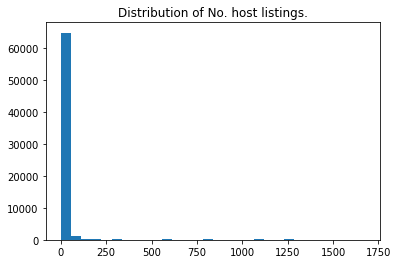

In [51]:
plt.figure()
plt.title('Distribution of No. host listings.')
plt.hist(eda['host_total_listings_count'],bins=30)
plt.show()

We have some huge outliers here, with the majority of values less than 100. Let's clean this up.

In [52]:
eda['host_total_listings_count'].value_counts(
).sort_index(ascending=False).head(20)

1677.0     23
1614.0     72
1522.0     71
1235.0    241
1108.0    106
814.0     160
695.0       8
641.0      14
640.0       1
593.0     341
528.0      18
516.0      14
488.0      24
472.0       8
441.0      18
408.0      33
362.0       1
349.0       4
332.0       4
314.0      26
Name: host_total_listings_count, dtype: int64

So we have a significant number of hosts with hundreds of listings. Some of these *could* be errors because I it's difficult to imagine people owning over a thousand airbnb listings. In a work setting, this'd be worth following up. However, I'm going to discretize these into bins to make these groups easier to compare.

I'll make a categorical column to distinguish between hosts. Here are the bins I'm going to use...
- 1 unit
- 2-10 units
- 11-50 units
- 51-100 units
- 101+

In [53]:
bins = [0,1,10,50,100,np.inf]
labels = ['1','2-10','11-50','51-100','101+']
eda['cat_num_units'] = pd.cut(eda['host_total_listings_count'],bins=bins,labels=labels)

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Now plotting the bins...

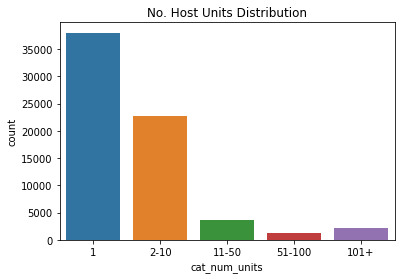

In [54]:
plt.figure()
sns.countplot(x='cat_num_units',data=eda)
plt.title('No. Host Units Distribution')
plt.show()

Let's compare these categories on their ratings.

In [55]:
rating_cols = ['review_scores_rating', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [56]:
def highlight_max(s):
    '''
    highlight the maximum in a Series lightgreen.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the minimum in a Series red.
    '''
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

In [57]:
eda.groupby('cat_num_units')[rating_cols].mean().transpose().style. \
    apply(highlight_max, axis=1).apply(highlight_min, axis=1)

cat_num_units,1,2-10,11-50,51-100,101+
review_scores_rating,95.1033,94.3074,91.2667,91.5408,93.6839
review_scores_cleanliness,9.39855,9.38816,9.14122,9.31654,9.54651
review_scores_checkin,9.81121,9.78747,9.63401,9.5491,9.47831
review_scores_communication,9.83415,9.78231,9.53695,9.53428,9.45503
review_scores_location,9.64073,9.5636,9.57101,9.47158,9.66455
review_scores_value,9.51381,9.42233,9.05917,8.92626,9.06561


Looks like hosts with only 1 unit appear to have the *highest average rating and scores*. Let's look at their boxplot summaries side-by-side to compare.

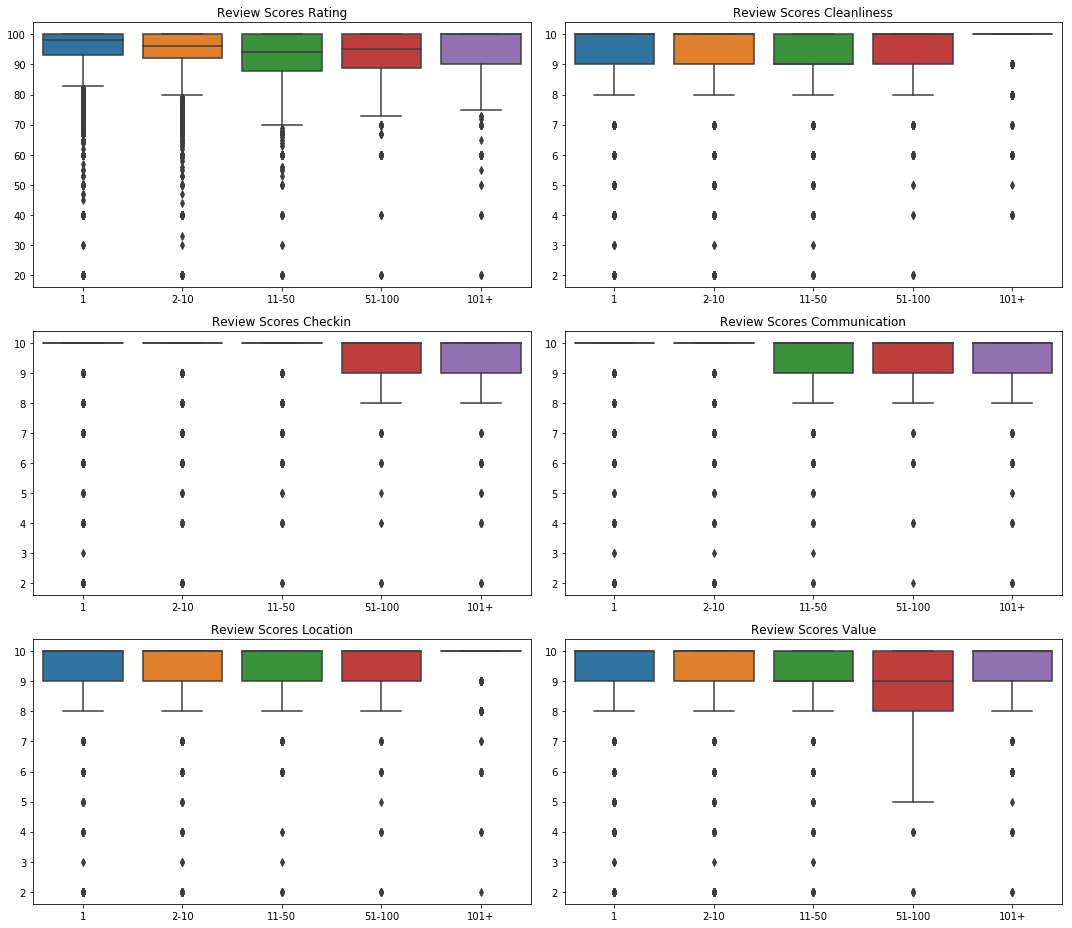

In [58]:
plt.figure(1,figsize=(15,13))
i = 1

for col in rating_cols:
    plt.subplot(3,2,i)
    sns.boxplot(x='cat_num_units',y=col,data=eda)
    title = col.replace('_',' ').title()
    plt.title(title)
    plt.ylabel(None)
    plt.xlabel(None)
    i += 1

plt.tight_layout()    
plt.show()

### Conclusion ###
So these plots tell me that hosts with only 1 unit have *tighter* and *higher* distributions, suggesting that these hosts are rated slightly better than hosts with more units. However, it's worth noting that...

1. this difference looks very marginal, and 
2. observations on hosts with more than 10 units may be slightly misleading since our sample sizes for these buckets are *much smaller* than hosts with 1 unit and hosts with 2-10 units.

#### Hypothesis Testing ####

Let's perform a simple hypothesis t-test with a 5% significance level to check whether the average `Review Scores Rating` for hosts with 1 unit is greater than ratings of all other hosts. 

---
First let's check our conditions for hypothesis testing using the Central Limit Theorem...
1. Independence: I picked listing data from 3 of the largest cities in the US, and these listings were scraped off of Airbnb's website and represent a snapshot of these listings at a given point in time. Therefore, It's important to note that these listings *were not randomly sampled*. Additionally, it feels wrong to assume that ratings within each of these cities are independent of one another, since ratings of some listings can affect how guests rate other listings. *Therefore, this test cannot reliably be generalized to the population of all Airbnb listings around the world. However, I will still proceed so I can practice hypothesis testing.*
2. Sample Size & Skew: Because our sample size (>60,000) is greater than 30, we can reliable assume that this sampling distribution would be normally distributed if we continued to take samples of 50,000 listings.

**Experiment Details**

$ H_0: u_{1 unit} = u_{all others}$ <br>
$ H_A: u_{1 unit} > u_{all others}$ <br>
$\alpha = 0.05$


In [378]:
# Creating sampling arrays
one_unit_samp = eda[eda['cat_num_units'] == '1']['review_scores_rating']
all_others_samp = eda[eda['cat_num_units'] != '1']['review_scores_rating']

# Calculating Variance
one_unit_var = one_unit_samp.var()
all_others_var = all_others_samp.var()

In [380]:
# Variances are nearly the same
print(one_unit_var)
print(all_others_var)

60.04818004883296
69.84990857907735


In [381]:
t_stat, p_val = ttest_ind(
    a=one_unit_samp, b=all_others_samp, equal_var=True, nan_policy='omit')

In [382]:
# Plotting a T-distribution with the calculated t-statistic annotated
df = min([len(one_unit_samp)-1, len(all_others_samp)-1])
plot_t_dist_hyp(df, t_stat, p_val)

**Results**

$t \approx 17.87$ <br>
${p_{value}} \approx 0$

Thus, after performing a t-test comparing the ratings between hosts with only 1 unit and all other hosts, we reject our null hypothesis (that the average ratings between the two groups are the same) in favor of the alternative ($H_A$), providing convincing evidence that hosts with only one unit are rated higher than hosts with more than 1 unit.

## Exploratory Question 2

*Do hosts with no recent reviews change pricing behavior from hosts with recent reviews?*

In [59]:
eda[['last_review_discrete', 'last_review_days']]

,last_review_discrete,last_review_days
0,last 90 days,61.0
1,last 2 years,709.0
2,more than 2 years,967.0
3,last year,307.0
4,last year,339.0
5,last 90 days,58.0
6,last 90 days,56.0
7,last 90 days,45.0
8,last 90 days,60.0
9,last year,227.0


In [60]:
eda[['property_type', 'room_type']]

,property_type,room_type
0,Apartment,Entire home/apt
1,Apartment,Entire home/apt
2,Apartment,Private room
3,Apartment,Private room
4,House,Entire home/apt
5,Apartment,Entire home/apt
6,Condominium,Private room
7,House,Private room
8,House,Entire home/apt
9,Apartment,Entire home/apt


In [61]:
eda['price']

0        170.0
1        235.0
2         65.0
3         65.0
4        685.0
5        255.0
6        139.0
7        135.0
8        265.0
9        177.0
10       194.0
11       139.0
12        85.0
13        85.0
14        79.0
15       166.0
16       215.0
17       450.0
18       107.0
19       110.0
20       125.0
21        65.0
22       100.0
23       155.0
24       180.0
25       155.0
26        79.0
27       195.0
28       150.0
29       110.0
30       125.0
31       110.0
32       450.0
33       150.0
34       199.0
35       220.0
36       155.0
37       150.0
38       107.0
39        94.0
40       108.0
41        83.0
42       159.0
43       125.0
44       136.0
45       170.0
46        85.0
47        85.0
48       150.0
49       120.0
50       175.0
51       116.0
52       125.0
         ...  
68115     69.0
68116     29.0
68117     69.0
68118     29.0
68119     59.0
68120     39.0
68121     39.0
68122    200.0
68123     32.0
68124    799.0
68125    199.0
68126     40.0
68127     

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


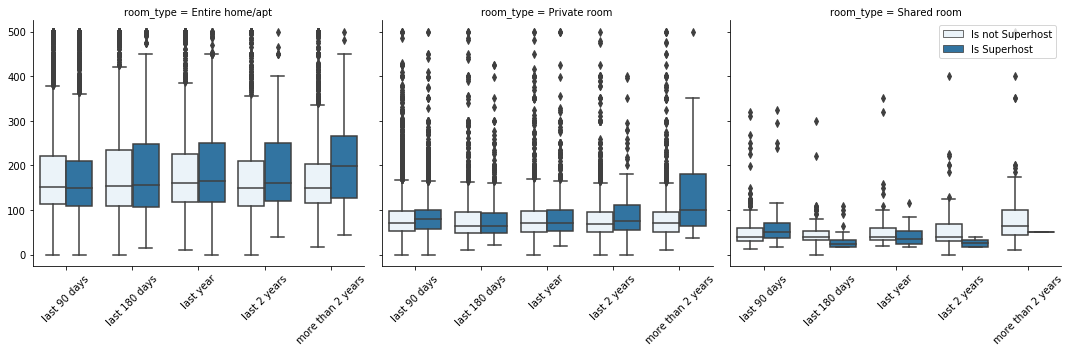

In [62]:
# Plotting facet grid to compare box plots for each kind of room type. Also filtered out outlier prices (>500)
fgrid = sns.FacetGrid(eda[eda['price'] <= 500], col='room_type', height=5,)
fgrid.map(sns.boxplot, 'last_review_discrete', 'price', 'host_is_superhost')
for ax in fgrid.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set(xlabel=None, ylabel=None)

l = plt.legend(loc='upper right')
l.get_texts()[0].set_text('Is not Superhost')
l.get_texts()[1].set_text('Is Superhost')

fgrid.fig.tight_layout(w_pad=1)

### Conclusion ###
Looking at the faceted plots above, it seems that units that haven't been reviewed for a long time are priced *slightly* higher than units with more recent reviews. Also, it appears that superhosts' pricing (dark blue) is higher than non-superhosts (light blue), suggesting that hosts who are verified as [superhosts](https://www.airbnb.com/superhost) (hosts who are top-rated and most experienced) are priced higher than those who are not.

## Exploratory Question 3 ##
*What are the strongest predictors for price?* 

**This question requires deeper analysis using machine learning techniques. Let's revisit this later.**

# Preparing Data for ML

We need to prepare the data so we can pass it through our ML algorithms. This entails...

1. Removing or imputing missing data
2. Encoding our categorical data
3. Scaling our data

## Assessing Missing Data

In [63]:
cleaned_df = cleaned_df.drop(['last_review_discrete'], axis=1)

### Per Column

In [64]:
# Calculating proportion of NA values in each column
prop_na = cleaned_df.isna().sum()/len(cleaned_df)
prop_na_05 = prop_na[prop_na > .05]
prop_na_05 = prop_na_05.sort_values(0, ascending=True).reset_index()

Plotting proportion of NA values for all columns where more than 5% is missing. The six columns in red will be removed since they are missing > 30% of their values.

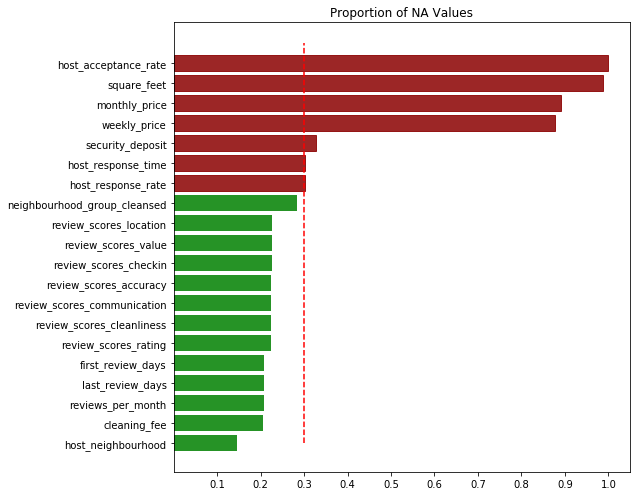

In [65]:
plt.figure(figsize=(9, 7))

barh = plt.barh(prop_na_05['index'], prop_na_05[0], alpha=0.85, color='green')
for i in range(7):
    i += 1
    barh[-i].set_color('darkred')

plt.title('Proportion of NA Values')
plt.vlines(x=.3, ymin=0, ymax=20, color='red', linestyles='dashed')
plt.xticks(np.arange(.1, 1.01, .1))

plt.tight_layout()

In [66]:
drop_na_cols = ['host_acceptance_rate', 'square_feet', 'monthly_price', 'weekly_price',
                'security_deposit', 'host_response_rate', 'host_response_time']
cleaned_df = cleaned_df.drop(drop_na_cols, axis=1)

Taking a look at `neighbourhood_group_cleansed` as well.

In [67]:
cleaned_df['neighbourhood_group_cleansed'].value_counts()

Manhattan        21790
Brooklyn         20019
Queens            5588
Bronx             1048
Staten Island      356
Name: neighbourhood_group_cleansed, dtype: int64

Looks like it is only relevant to the `New York` dataset, so I think it's safe to drop.

In [68]:
cleaned_df = cleaned_df.drop('neighbourhood_group_cleansed',axis=1)

### Per Row

In [69]:
cleaned_df['sum_na_row'] = cleaned_df.isna().sum(axis=1)

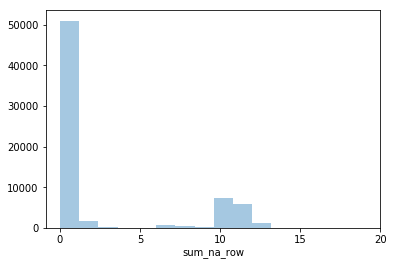

In [70]:
plt.figure()
sns.distplot(cleaned_df['sum_na_row'], bins=15, kde=False)
plt.xticks(np.arange(0, 21, 5))
plt.show()

Let's take a look at the rows missing 10 or more values.

In [71]:
temp = cleaned_df[cleaned_df['sum_na_row'] >= 10].isna().any().reset_index()
na_cols = temp[temp[0] == True]['index'].values
cleaned_df[cleaned_df['sum_na_row'] >= 10][na_cols].transpose()

,130,255,407,492,539,642,782,793,892,940,...,68158,68159,68160,68161,68162,68163,68164,68165,68166,68167
host_listings_count,2,1,2,1,1,1,4,0,1,1,...,3,6,1,1,2,1,2,2,1,1
host_total_listings_count,2,1,2,1,1,1,4,0,1,1,...,3,6,1,1,2,1,2,2,1,1
bathrooms,3.5,1,1.5,2,1,1.5,2,1,1,1,...,1,1,2,1,1,1,1,1.5,1,NaN
bedrooms,4,1,1,2,0,1,2,4,0,1,...,0,1,2,1,1,1,1,1,1,1
beds,5,1,1,2,1,1,3,4,1,2,...,1,1,2,1,1,1,1,1,2,1
review_scores_rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_checkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_communication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NA values related to reviews are most likely missing because this particular unit does not have any reviews. This could be useful information, so I'll encode these values as 0 so they're different from the values that we do have.

Although 0 may be misleading, I believe filling with 0 is better than simply removing the rows or imputing based on other values to maintain its variance from units have reviews.

In [72]:
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'reviews_per_month', 'first_review_days', 'last_review_days']

In [73]:
cleaned_df[review_cols].head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,first_review_days,last_review_days
0,97.0,10.0,10.0,10.0,10.0,10.0,9.0,1.60,3645.0,61.0
1,98.0,10.0,10.0,10.0,10.0,10.0,9.0,0.90,3726.0,709.0
2,85.0,8.0,8.0,9.0,9.0,9.0,8.0,0.14,3606.0,967.0
3,93.0,9.0,9.0,10.0,10.0,9.0,9.0,0.14,1772.0,307.0
4,97.0,10.0,10.0,10.0,10.0,10.0,9.0,0.23,3581.0,339.0


In [74]:
cleaned_df[review_cols] = cleaned_df[review_cols].fillna(value=0)

It doesn't really make any sense to impute the `host_neighbourhood` or the `neighbourhood` features, so I'll drop the rows that're missing these values

In [75]:
na_neigh = cleaned_df[(cleaned_df['host_neighbourhood'].isna()) | (
    cleaned_df['neighbourhood'].isna())].index

In [76]:
print(
    f'Dropping {na_neigh.shape[0]} rows due to missing values in neighborhood columns.')

Dropping 9930 rows due to missing values in neighborhood columns.


In [77]:
cleaned_df = cleaned_df.drop(na_neigh)

State

In [78]:
cleaned_df[cleaned_df['state'].isna()][['state', 'neighbourhood',
                                        'smart_location']]

,state,neighbourhood,smart_location
8548,NaN,Ozone Park,"NY,"
44558,NaN,Harlem,"New York,"
47152,NaN,Manhattan,"US,"
56454,NaN,Travis Heights,"US,"


The first three are NY, and the last one is TX

In [79]:
update_state = cleaned_df[cleaned_df['state'].isna(
)][['state', 'neighbourhood', 'smart_location']].index
cleaned_df.loc[update_state[:3]
               ]['state'] = cleaned_df.loc[update_state[:3]]['state'].fillna('NY')

In [80]:
for i in update_state[:3]:
    cleaned_df.at[i, 'state', ] = 'NY'

In [81]:
cleaned_df.at[update_state[-1], 'state', ] = 'TX'

#### Bathrooms, Bedrooms, and Beds

These features have some very common modes that I will use to impute their values.

In [82]:
bbb = ['bathrooms', 'bedrooms', 'beds']

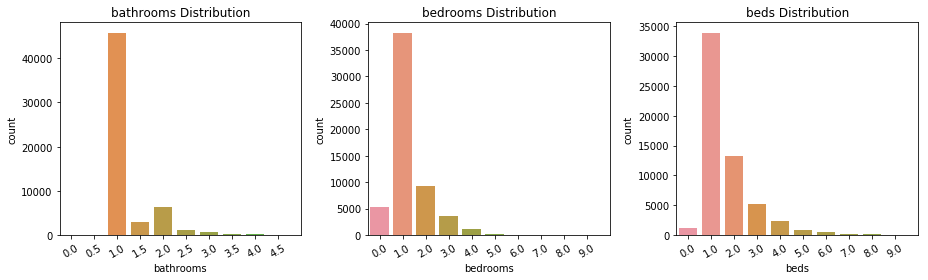

In [83]:
plt.figure(figsize=(13, 4))
i = 1
for col in bbb:
    plt.subplot(1, 3, i)
    sns.countplot(x=col, data=cleaned_df)
    plt.title(col+' Distribution')
    plt.xticks(np.arange(0, 10, 1, dtype=np.int64), rotation=30)
    plt.xlim(right=10)
    i += 1

plt.tight_layout()

In [84]:
# Filling with mode (denoted by highest bar in plots above)
for col in bbb:
    cleaned_df[col] = cleaned_df[col].fillna(cleaned_df[col].mode()[0])

In [85]:
cleaned_df[bbb].isna().sum()

bathrooms    0
bedrooms     0
beds         0
dtype: int64

In [86]:
cleaned_df.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,photographer,reviews,selfie,sent_id,sesame,sesame_offline,weibo,work_email,zhima_selfie,sum_na_row
0,1.0,1.0,37.76931,-122.43386,3,1.0,1.0,2.0,2,1,...,0,1,0,0,0,0,0,0,0,0
1,2.0,2.0,37.74511,-122.42102,5,1.0,2.0,3.0,2,30,...,0,1,0,0,0,0,0,1,0,0
2,10.0,10.0,37.76669,-122.45250,2,4.0,1.0,1.0,1,32,...,0,1,0,0,0,0,0,0,0,0
3,10.0,10.0,37.76487,-122.45183,2,4.0,1.0,1.0,1,32,...,0,1,0,0,0,0,0,0,0,0
4,2.0,2.0,37.77525,-122.43637,5,1.5,2.0,2.0,2,4,...,0,1,0,0,0,0,0,0,0,0


#### Feature Scaling (For `IterativeImputer`)

I'd like to practice using the `IterativeImputer` to impute missing values for the `cleaning_fee` feature. However, before we use `IterativeImputer` to impute the missing values, 1) the features need to be numerical and 2) they should be standardized.

However, we will have a lot of features if I use all that is available, making imputation very computationally expensive. So, I'm going to simplify the problem by doing the following...
1. Pick out a smaller number of numerical features that I can use to predict the missing values
2. Standardize these features
3. Predict missing values
4. Re-insert these values (with imputed NA values) back into the DataFrame.

In [87]:
features_for_imputer = ['accommodates', 'bathrooms', 'bedrooms', 'beds',
                        'guests_included', 'review_scores_rating', 'price', 'cleaning_fee']

In [88]:
df_impute = cleaned_df[features_for_imputer]

In [89]:
std = StandardScaler()
std_df_impute = std.fit_transform(df_impute)

In [90]:
std_df_impute = pd.DataFrame(data=std_df_impute, columns=df_impute.columns)

In [91]:
# These rows do not have missing values
rows_all_vals = std_df_impute[std_df_impute['cleaning_fee'].notnull()]

Instantiating the Imputer

In [92]:
imp = IterativeImputer(max_iter=5)

In [93]:
imp.fit(rows_all_vals)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=5, max_value=None, min_value=None, missing_values=nan,
                 n_nearest_features=None, random_state=None,
                 sample_posterior=False, tol=0.001, verbose=0)

---

In [94]:
rescaled_data = std.inverse_transform(imp.transform(std_df_impute))

In [95]:
# Calling the imputer on the subset of our DataFrame
imputed_std_df = pd.DataFrame(rescaled_data, columns=df_impute.columns)
imputed_std_df.head()

,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,price,cleaning_fee
0,3.0,1.0,1.0,2.0,2.0,97.0,170.0,100.0
1,5.0,1.0,2.0,3.0,2.0,98.0,235.0,100.0
2,2.0,4.0,1.0,1.0,1.0,85.0,65.0,50.0
3,2.0,4.0,1.0,1.0,1.0,93.0,65.0,50.0
4,5.0,1.5,2.0,2.0,2.0,97.0,685.0,225.0


In [96]:
# Sanity checking before re-inserting back into the DataFrame
imputed_std_df.shape == df_impute.shape == cleaned_df[features_for_imputer].shape

True

Resetting indices so they can be concatennated

In [97]:
cleaned_df = cleaned_df.reset_index().drop('index', axis=1)

In [98]:
cleaned_df[features_for_imputer] = imputed_std_df

In [99]:
# Sanity Check - no NA values
cleaned_df.isna().any().sum()

0

## Splitting Data

Now we're going to split the data into an X-matrix of features and y-array for `price` to figure out which features are the strongest predictors of price.

I've decided not to split my data into a training and testing set because we're simply using some ML algorithms to *figure out which features are most important when predicting price*. I'm not really concerned with using a testing set to figure out how well the algorithms are doing.

In [100]:
X = cleaned_df.drop(['price', 'sum_na_row'], axis=1)
y = cleaned_df['price']

## Encoding Categorical Values

In [101]:
cat_cols = X.select_dtypes('object').columns
print('Unique Values per categorical column...')
for col in cat_cols:
    print(f'{col}: {X[col].nunique()}')

Unique Values per categorical column...
experiences_offered: 1
host_neighbourhood: 605
neighbourhood: 316
neighbourhood_cleansed: 291
state: 7
smart_location: 220
country_code: 1
country: 1
property_type: 41
room_type: 3
bed_type: 5
has_availability: 1
is_business_travel_ready: 1
cancellation_policy: 6


We don't need any of the categorical columns with only 1 value.

In [102]:
# Tracking all the columns I drop so I drop these in the test set as well
drop_cols = ['experiences_offered','country_code','country','has_availability','is_business_travel_ready']

Let's take a look at some of these columns to see if we can easily just get rid of some of them.

In [103]:
X[['host_neighbourhood', 'neighbourhood',
    'neighbourhood_cleansed', 'smart_location']].head(10)

,host_neighbourhood,neighbourhood,neighbourhood_cleansed,smart_location
0,Duboce Triangle,Lower Haight,Western Addition,"San Francisco, CA"
1,Bernal Heights,Bernal Heights,Bernal Heights,"San Francisco, CA"
2,Cole Valley,Cole Valley,Haight Ashbury,"San Francisco, CA"
3,Cole Valley,Cole Valley,Haight Ashbury,"San Francisco, CA"
4,Alamo Square,Alamo Square,Western Addition,"San Francisco, CA"
5,Western Addition/NOPA,Western Addition/NOPA,Western Addition,"San Francisco, CA"
6,Mission District,Mission District,Mission,"San Francisco, CA"
7,Potrero Hill,Potrero Hill,Potrero Hill,"San Francisco, CA"
8,Mission District,Mission District,Mission,"San Francisco, CA"
9,Lower Haight,Lower Haight,Haight Ashbury,"San Francisco, CA"


I don't really know the difference between each of the neighbourhood columns. In a work setting, I'd follow up with someone that knows this dataset well to understand how to use these columns. For simplicity, I'll just move forward with `neighborhood`. I'm also going to drop `smart_location` because it's redundant to `neighbourhood` and a bit less granular.

In [104]:
drop_cols.extend(['host_neighbourhood','neighbourhood_cleansed','smart_location'])

Let's take a look at `property_type`.

In [105]:
X['property_type'].value_counts()

Apartment                 38470
House                      9441
Condominium                2655
Townhouse                  1946
Loft                       1461
Guest suite                 971
Serviced apartment          805
Guesthouse                  513
Boutique hotel              379
Bungalow                    348
Hotel                       222
Hostel                      189
Other                       168
Bed and breakfast           145
Resort                      118
Camper/RV                    84
Villa                        67
Aparthotel                   63
Cottage                      60
Tiny house                   47
Cabin                        16
Tent                         16
Boat                          7
Campsite                      7
Earth house                   6
Casa particular (Cuba)        5
Dome house                    4
Treehouse                     4
Farm stay                     3
Castle                        2
Barn                          2
Timeshar

This could be a valuable predictor, since I'd guess that a Villa would be priced higher than a Hostel.

In [106]:
# Dropping the columns
X = X.drop(drop_cols, axis=1)

In [107]:
X.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,phone,photographer,reviews,selfie,sent_id,sesame,sesame_offline,weibo,work_email,zhima_selfie
0,1.0,1.0,37.76931,-122.43386,3.0,1.0,1.0,2.0,2.0,1,...,1,0,1,0,0,0,0,0,0,0
1,2.0,2.0,37.74511,-122.42102,5.0,1.0,2.0,3.0,2.0,30,...,1,0,1,0,0,0,0,0,1,0
2,10.0,10.0,37.76669,-122.45250,2.0,4.0,1.0,1.0,1.0,32,...,1,0,1,0,0,0,0,0,0,0
3,10.0,10.0,37.76487,-122.45183,2.0,4.0,1.0,1.0,1.0,32,...,1,0,1,0,0,0,0,0,0,0
4,2.0,2.0,37.77525,-122.43637,5.0,1.5,2.0,2.0,2.0,4,...,1,0,1,0,0,0,0,0,0,0


Now let's OneHotEncode our columns

In [108]:
ohe = OneHotEncoder(handle_unknown='value', use_cat_names=True,
                    return_df=True, handle_missing='value')

In [109]:
X = ohe.fit_transform(X)

In [110]:
X.head()

,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,phone,photographer,reviews,selfie,sent_id,sesame,sesame_offline,weibo,work_email,zhima_selfie
0,1.0,1.0,37.76931,-122.43386,3.0,1.0,1.0,2.0,2.0,1,...,1,0,1,0,0,0,0,0,0,0
1,2.0,2.0,37.74511,-122.42102,5.0,1.0,2.0,3.0,2.0,30,...,1,0,1,0,0,0,0,0,1,0
2,10.0,10.0,37.76669,-122.45250,2.0,4.0,1.0,1.0,1.0,32,...,1,0,1,0,0,0,0,0,0,0
3,10.0,10.0,37.76487,-122.45183,2.0,4.0,1.0,1.0,1.0,32,...,1,0,1,0,0,0,0,0,0,0
4,2.0,2.0,37.77525,-122.43637,5.0,1.5,2.0,2.0,2.0,4,...,1,0,1,0,0,0,0,0,0,0


In [111]:
X.shape

(58237, 661)

In [112]:
feature_names = X.columns.values

In [113]:
feature_names.shape

(661,)

## Feature Scaling (All)

Now standardizing our train data using the `StandardScaler`.

In [114]:
std = StandardScaler()

In [115]:
X = std.fit_transform(X)

In [116]:
X.shape

(58237, 661)

## Feature Selection / Dimensionality Reduction

### ANOVA

I'd like to practice using ANOVA since I haven't used it before. So, I'm using ANOVA to initially select the best 30% features

In [117]:
fvalue_selector = SelectPercentile(f_classif, percentile=30)

In [118]:
X_best = fvalue_selector.fit_transform(X,y)

/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [649] are constant.
  UserWarning)
/Users/patrickdeguzman/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [119]:
mask = fvalue_selector.get_support(indices=True)

In [120]:
f_val_features = feature_names[mask]

In [121]:
X_best.shape

(58237, 199)

### PCA

I'd also like to further reduce dimensionality by running PCA on our best 30% features found with ANOVA above.

I want to have enough components to have 85% variance explained, so I'll test run with 75 components to see how much variance that explains, and go from there.

In [122]:
pca = PCA(75)

In [123]:
X_pca = pca.fit_transform(X_best)

In [124]:
pca.explained_variance_ratio_.sum()

0.7179129999234619

So we have about 72% variance explained with the first 75 principal components. Let's keep going until we have 85%.

In [125]:
n_components = [100, 105, 110, 115, 120, 125]
for n in n_components:
    pca = PCA(n)
    X_pca = pca.fit_transform(X_best)
    if pca.explained_variance_ratio_.sum() >= .85:
        break

print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

0.8666531501852338
110


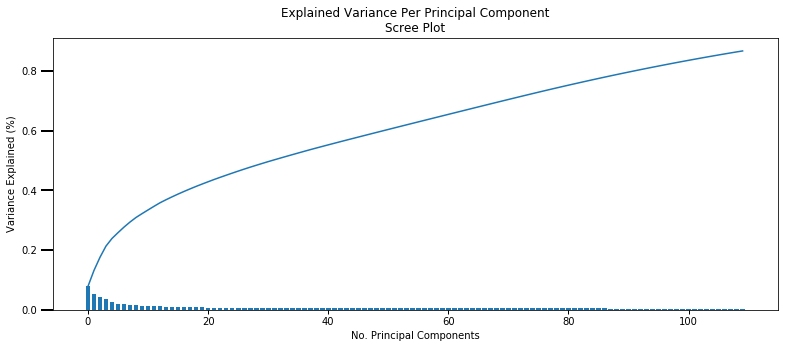

In [126]:
ticks = np.arange(pca.n_components)
values = pca.explained_variance_ratio_

plt.figure(figsize=(13, 5))
ax = plt.subplot(111)
cumvals = np.cumsum(values)
ax.bar(ticks, values)
ax.plot(ticks, cumvals)

ax.xaxis.set_tick_params(width=1)
ax.yaxis.set_tick_params(width=2, length=12)

ax.set_xlabel("No. Principal Components")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component\nScree Plot')
plt.show()

So we now have 110 principal components that explain 87% of our variance. Let's keep going.

### Recursive Feature Elimination with Cross Validation

RFECV can be a very useful tool to figure out which features are most important. It will train a model on all features, score it via cross validation, then recursively eliminate features and score until the score doesn't increase anymore.

In theory, we are left with the most important features (in our case, principal components). Let's see what we get using a Linear model on our principal components...

In [127]:
ols = LinearRegression()

In [128]:
rfecv_ols = RFECV(estimator=ols, step=1,
                  scoring='neg_mean_squared_error', cv=3)

In [129]:
%time rfecv_ols.fit(X_pca, y)

CPU times: user 54.6 s, sys: 3.71 s, total: 58.3 s
Wall time: 34.7 s


RFECV(cv=3,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [136]:
rfecv_ols.n_features_

5

In [131]:
pc_kept = []
i = 1
print('Principal Components Kept...')
for boolean in rfecv_ols.support_:
    if boolean == True:
        print(f'Principal Component {i}')
        pc_kept.append(i)
    i += 1

Principal Components Kept...
Principal Component 3
Principal Component 4
Principal Component 7
Principal Component 9
Principal Component 20


In [222]:
print('Respective Linear Regression Princpal Component Coefficients...\n')
for comp, coef in zip(pc_kept, rfecv_ols.estimator_.coef_):
    print(f'PC{comp}: {coef:.5f}')

Respective Linear Regression Princpal Component Coefficients...

PC3: -25.91075
PC4: -26.06227
PC7: 33.92885
PC9: 23.89627
PC20: 27.11547


Now we have enough information for **quick and dirty** analysis. We *can* pick a few of these Principal Components and try to interpret what they describe, but first, I'd like to run a RandomForest ensemble and compare the RandomForest's `feature_importances_` to this list of principal components leftover from `RFECV`.

# ML Model Training & Feature Importances

I want to see if a trained Random Forest regressor's `feature_importancees_` agrees with our findings from RFECV. Below, I'll train a Random Forest on the 30% best features we found through ANOVA.

In [132]:
rf_reg = RandomForestRegressor(n_estimators=75)

In [133]:
rf_reg.fit(X_best, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [134]:
i = 1
component_names = []
while i <= len(rf_reg.feature_importances_):
    comp_name = 'Comp ' + str(i)
    component_names.append(comp_name)
    i += 1

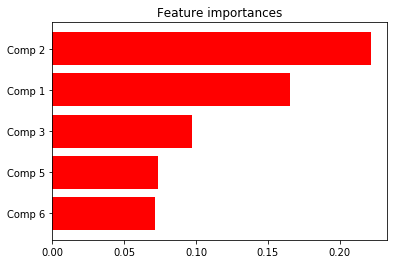

In [137]:
importances = rf_reg.feature_importances_

# Grabbing the top 15 indices that would sort the feature importances according to their importance rating
indices = np.argsort(importances)[-5:]

# Grabbing an array of all the feature names
features = np.array(component_names)

# Plotting
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices],
         color="r", align="center")
plt.yticks(range(len(indices)), features[indices])
plt.show()

According to our Random Forest Regressor, the plot above shows the top most important Principal Components. 

Let's compare this to our RFECV most important Principal Components.

---
## Revisiting Exploratory Question 3

Now that we have a clearer picture of the the most important Principal Components per RFECV with Linear Regression and Random Forest Regression, we're ready to tackle the question...

*What are the strongest predictors for price?* 

---

But first, a quick recap of what we've done since our initial Exploratory Data Analysis:

1. Prepared Data for ML Algorithms (Removed some rows & columns, imputed missing values, feature scaling, and encoding)
2. Reduced Dimensionality via ANOVA, then PCA
3. Algorithm Analysis
    - Performed RFECV with a LinearRegression algorithm to obtain a list of 5 components that were the optimum 5 features to use with a Linear Model
    - Trained a Random Forest Regressor on our dataset to obtain the top 5 most important components calculated by the Random Forest algorithm.
5. Now we're comparing these principal components and interpretting them to understand **what are important predictors for price**.

Below is a table summary showing the 5 components left after performing RFECV and the top 5 most important components per Random Forest Regression

| Principal Component | From RFECV | From RF Reg |
| --- | --- | --- |
| Principal Component 1 | - | x |
| Principal Component 2 | - | x |
| Principal Component 3 | x | x |
| Principal Component 4 | x | - |
| Principal Component 5 | - | x |
| Principal Component 6 | - | x |
| Principal Component 7 | x | - |
| Principal Component 9 | x | - |
| Principal Component 20 | x | - |


As you can see, both analyses highlighted principle component 3. Let's examine the features in this component. Additionally, the largest positive coefficient from the Linear Regression used in RFECV is associated with Principal Component 7, and the most important feature per the Random Forest Regressor is Principal Component 2, so we'll take a look at these as well.

In [254]:
def plot_pca_dim(pca, feat_names, dim, features, fontsize=8):
    '''
    For a given fitted PCA object, the given component, and a given number of features, this plots
    the scaled coefficients for this particular component.

    Inputs:
    pca: PCA object
    feat_names: feature names from original pre-PCA dataset
    dim: component that you want to inspect
    features: number of most positive and most negative features to display

    '''

    names_to_weights = sorted(
        zip(pca.components_[dim], feat_names), reverse=False)
    names_to_weights = np.array(names_to_weights)

    nm_to_wt_df = pd.DataFrame(names_to_weights, columns=['coef', 'feature'])
    nm_to_wt_df = pd.concat(
        [nm_to_wt_df.head(features), nm_to_wt_df.tail(features)])
    nm_to_wt_df['coef'] = nm_to_wt_df['coef'].astype(float)

    fig = px.bar(nm_to_wt_df, y='feature', x='coef',
                 color='coef', color_continuous_scale=px.colors.sequential.Sunsetdark,
                 labels={'coef': 'Coefficients', 'feature': ''},
                 height=450, width=800, orientation='h', title='Principal Component '+str(dim+1)+' Coefficients',
                 hover_name='feature')

    fig.update_yaxes(tickfont=dict(size=fontsize))
    fig.update_xaxes(tickfont=dict(size=fontsize))

    return fig

In [291]:
def get_index_where_value(arr, value):
    """
    Returns index of array where that array's value equals input value.

    Inputs...
    arr: input array to search
    value: value to search

    Returns: Index Position or None
    """
    try:
        return np.argwhere(np.where(arr == value, arr, None))[0][0]
    except:
        return None

## Component 3

In [255]:
fig_3 = plot_pca_dim(pca, f_val_features, 2, 10)
fig_3

This component has a relatively large association with New York and room type, and has negative associations with some amenities, so I interpret this as measuring New York apartment listings as predictors of unit price. Consequently, this punishes non-NY listings beause our feature value for `state_NY` is *negative* (due to standardization with `StandardScaler`) for non-NY listings. This doesn't provide very much value since it's focused on one particular state, and this probably stems from the fact that this dataset is heavily imbalanced in favor of New York listings. Intuitively, it's difficult to interpret the reason this component has such strong negative associations with amenities. Therefore, I'll interpret these as un-important price adjustments that the algorithm learned to help it predict `price` with more accuracy for NY listings.

## Component 7

In [242]:
fig_7 = plot_pca_dim(pca, f_val_features, 6, 10)
fig_7

This component has a very strong positive association with one room type `Entire home/apt` and a very negative association with another `Private room`. It also is positively associated with `accomodates` (discrete variable for number of guests), `bedrooms`, `beds`, `family/kid friendly`, and `guests_included`. Therefore, this component measures the size of listings/units, valuing *larger* listings *higher* than smaller listings.

## Component 2

In [243]:
fig_2 = plot_pca_dim(pca, f_val_features, 1, 10)
fig_2

This component has very uniform coefficients related to amenities. Given the relatively *high* amenities coefficients, and given these amenities are associated with *luxury amenities* (`wine cellar`, `sun deck`, `steam room`, `rooftop`, etc - all things I would expect to find in a very *luxurious* listing), this component measures luxurious amenities, valuing listings higher if they have these.

---
# Conclusion

In sum, by exploring the Airbnb listings datasets for New York, San Francisco, and Austin, we've been able to answer the following questions...

1. Is there a difference in quality of service/product between hosts with different numbers of units? (i.e. do hosts with multiple units give better or worse service than those who do not?)
    - We measured quality of service by looking at the review ratings. We found that hosts with only one unit were reviewed slightly higher than hosts with more than 1 unit. I used an inferential hypothesis test to see whether the difference was statistically significant, and we found that *it was indeed a statistically significant difference*. However, we may not be able to generalize these findings since we did not fulfill the independence requirement for the Central Limit Theorem generalizability to hold.

2. Do hosts with no recent reviews change pricing behavior from hosts with recent reviews?
    - We discretized days since last review by placing each listing into one of several bins based on their days since last review, and we found (from a glance at side-by-side box plots) that pricing didn't appear to be different from a practical significance perspective between each of these bins. Note that we didn't dive into further statistical inference analysis like we did with our first question, which *could have proven statistical significance*. Futher, by separating bins on `is_superhost`, we found that, *visually*, pricing seemed higher for superhosts than non-superhosts.
    
3. What are the strongest predictors for price?
    - After proprocessing our data, we were left with *over 600 features*. We selected the best 30% features based on ANOVA (selected features with highest variance), futher decomposed the features into 110 principal components, then used 1) Recursive Feature Elimination with Cross Validation (RFECV) using a Linear Regression model *and* 2) Random Forest Regression to figure out which components were most important/significant when predicting `price`. By analyzing three of these "important" components, we found that the following attributes were mostly captured by these components...
       1. Principal Component 3: New York Apartments
       2. Principal Component 7: Size and capacity of listings
       3. Principal Component 2: Luxurious Amenities
    - We can interpret these latent features as being the strongest predictors of price for the algorithms that I used.